In [1]:
import os
import cv2
import dlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np 
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import albumentations as A
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input
from keras.models import Model 
from tqdm import tqdm
from keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

DATASET_PATH  = './dataset/lfw-deepfunneled/lfw-deepfunneled'
SEED= 123

def crop_face(img, faces_loc):
    faces = []
    for face in faces_loc:
        x, y, largura, altura = (face.left(), face.top(), face.width(), face.height())
        cropped_face = img[y:y+altura, x:x+largura]
        faces.append(cropped_face)
    return faces

def pre_processing_input(img, face_detector):
    faces = face_detector(img)
    faces_cropped =  crop_face(img, faces)
    return faces_cropped

def load_dataset(path):
    detector_faces = dlib.get_frontal_face_detector()
    LabelEncod = preprocessing.LabelEncoder()
    x, y = [],[]
    for person_filename in os.listdir(path):
        person_path = os.path.join(path, person_filename)
        for person_photo_filename in os.listdir(person_path):
            img = cv2.imread(os.path.join(person_path, person_photo_filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            faces_cropped = pre_processing_input(img, detector_faces)
            x += faces_cropped
            y += [person_filename for _ in range(len(faces_cropped))]
    LabelEncod.fit(y)
    assert len(x) == len(y)
    return np.array(x), np.array(y), LabelEncod

2024-01-24 18:10:23.505185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 18:10:24.560856: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/anaconda3/envs/matheus_levy_tensorflow/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.4/lib64:/usr/local/cuda-11.4/lib64:/usr/local/cuda-11.4/lib64:
2024-01-24 18:10:24.561043: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object fil

In [ ]:
!wget https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5

In [2]:
x, y, label_encoder = load_dataset(DATASET_PATH)

/tmp/ipykernel_2169104/2226217223.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x), np.array(y), LabelEncod


In [3]:
def train_val_test_split(x, y, train_split=0.7, val_split=0.1, test_split=0.2, seed=None):
    x_train, x_others, y_train, y_others = train_test_split(x, y, test_size=1 - train_split, random_state=seed)
    rest = 1 - train_split
    val_relative_proportion = val_split / rest
    x_val, x_test, y_val, y_test = train_test_split(x_others, y_others, test_size=test_split/(val_relative_proportion + test_split), random_state=seed)
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x, y, seed= SEED)

In [4]:
print(y_train)

['Hans_Blix' 'George_W_Bush' 'Kofi_Annan' ... 'Bill_Clinton'
 'Brian_Billick' 'Ibrahim_Jaafari']


In [5]:
def normalize_img(img):
    img = img.astype(np.float32)
    img_normalized = img/255.0
    return img_normalized

In [6]:
class SiameseDataLoaderTriplet(keras.utils.Sequence):
    def __init__(self, X, y, batch_size, image_shape, return_labels= False, Augmentation= False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.return_labels = return_labels
        self.image_resize = image_shape[:2]
        self.augmentation = Augmentation
        self.transform =  A.Compose([
            A.HorizontalFlip(p=0.5),  
            A.Rotate(limit=15, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.4),
    ])
        
    def _aug(self, img):
        augmented_image = self.transform(image=img)['image']
        return augmented_image
    
    def _pre_process(self, img):
       img = normalize_img(img)
       if self.augmentation:
            img = self._aug(img)
       try:
            img_resize = cv2.resize(img, self.image_resize)
       except cv2.error as e:
          raise
       return img_resize

    def _get_idx_anchor(self):
       return np.random.randint(0, len(self.X))
    
    def _get_idx_positive(self, idx_anchor):
       # Select a Positive Image. It should have the same label of the anchor
        anchor_label = self.y[idx_anchor]
        anchor_label_idxs = np.where(self.y == anchor_label)[0]
        idx_positive = np.random.choice(anchor_label_idxs)
        count = 0 
        # Assert that positive image is not the same anchor image 
        while idx_anchor == idx_positive: 
          idx_positive = np.random.choice(anchor_label_idxs)
          count += 1
          if count >= 5: # if it was random select 5x and it still the same so it will be the same as img of the anchor
            break
        return idx_positive
    
    def _get_idx_negative(self, idx_anchor):
        anchor_label = self.y[idx_anchor]
        negatives_idxs = np.where(self.y != anchor_label)[0]
        negative_idx = np.random.choice(negatives_idxs)
        return negative_idx

    def _get_anchor_img(self):
        while True:
            idx_anchor = self._get_idx_anchor()
            anchor_img = self.X[idx_anchor]
            try:
                anchor_img_processed = self._pre_process(anchor_img)
                break
            except cv2.error as e:
                pass
        return anchor_img_processed, idx_anchor

    def _get_positive_img(self, idx_anchor):
        while True:
            idx_positive = self._get_idx_positive(idx_anchor)
            positive_img = self.X[idx_positive]
            try:
                positive_img_processed = self._pre_process(positive_img)
                break
            except cv2.error as e:
                pass
        return positive_img_processed, idx_positive

    def _get_negative_img(self, idx_anchor):
        while True:
            idx_negative = self._get_idx_negative(idx_anchor)
            negative_img = self.X[idx_negative]
            try:
                negative_img_processed = self._pre_process(negative_img)
                break
            except cv2.error as e:
                pass
        return  negative_img_processed, idx_negative

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
      # Init a array with zeros for the triplets batchs
      triplet = [np.zeros((self.batch_size, *self.image_shape)) for _ in range(3)]
      labels = np.zeros((self.batch_size, 3))

      for i in range(self.batch_size):
          # Select a Anchor
          anchor_img, idx_anchor = self._get_anchor_img()
          triplet[0][i,] = self._pre_process(anchor_img)
          labels[i, 0] = idx_anchor

          # Select a Positive Image
          positive_img, idx_positive = self._get_positive_img(idx_anchor)
          triplet[1][i,] = self._pre_process(positive_img)
          labels[i, 1] = idx_positive

          # Select a Negative Image
          negative_img, idx_negative = self._get_negative_img(idx_anchor)
          triplet[2][i,] = self._pre_process(negative_img)
          labels[i, 2] = idx_negative

      triplet = [tf.convert_to_tensor(x) for x in triplet]
      labels = tf.convert_to_tensor(labels)

      if self.return_labels:
        return triplet, labels
      return triplet

2024-01-24 18:12:43.533055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-24 18:12:43.561222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-24 18:12:43.561810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-24 18:12:43.562679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

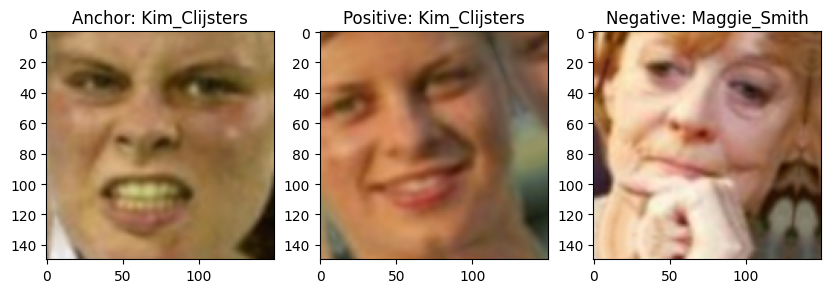

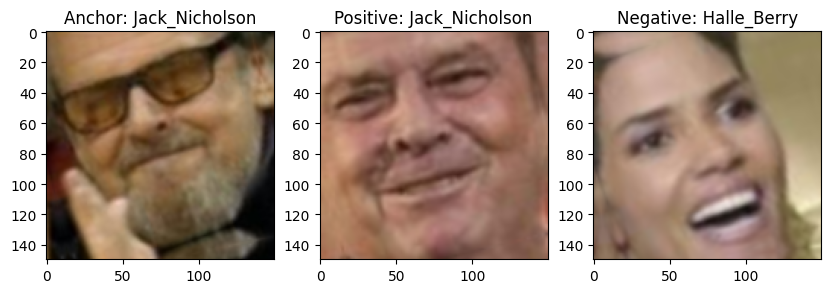

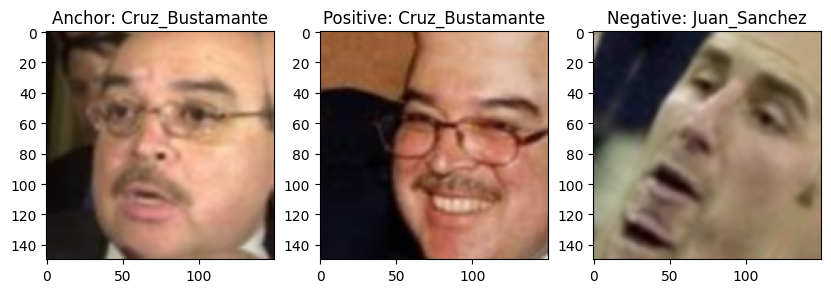

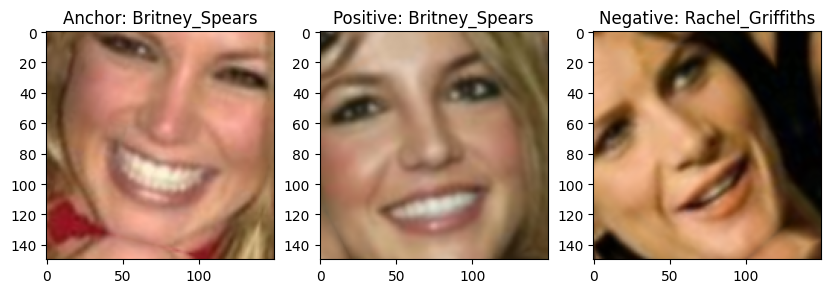

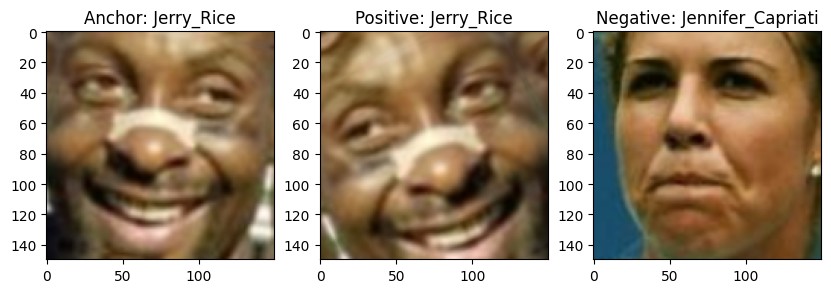

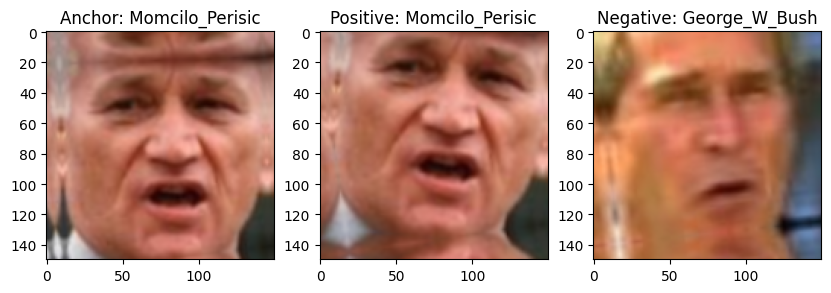

In [7]:
y_train_num = label_encoder.transform(y_train)
data_loader = SiameseDataLoaderTriplet(x_train, y_train_num, batch_size=1, image_shape= (150, 150, 3), return_labels= True, Augmentation=True)
for idx, sample in enumerate(data_loader):
  triplet, labels = sample
  labels = labels[0]
  anchor = triplet[0]
  positive = triplet[1]
  negative = triplet[2]
  imagem = anchor
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
  ax1.imshow(anchor[0]*255)
  ax1.set_title('Anchor: {}'.format(y_train[int(labels[0])]))
  ax2.imshow(positive[0]*255)
  ax2.set_title('Positive: {}'.format(y_train[int(labels[1])]))
  ax3.imshow(negative[0]*255)
  ax3.set_title('Negative: {}'.format(y_train[int(labels[2])]))
  if (idx == 5):
    break

In [8]:
def embedding_model(input_shape):
  vgg16 = VGG16(input_shape= input_shape, include_top= False)
  vgg16.load_weights('./weights/rcmalli_vggface_tf_notop_vgg16.h5')

  # FC Layer
  x = Flatten()(vgg16.output)
  x = Dense(512, activation='relu', name= 'fc0')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation="relu", name= 'fc1')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu', name = 'fc2')(x)
  x = BatchNormalization()(x)
  x = Dense(128, activation='linear', name = 'fc3')(x)
  embedding_network = Model(vgg16.input, x, name= 'Embbeding')
  return embedding_network

In [9]:
embedding_model = embedding_model(input_shape=(150, 150, 3))
embedding_model.layers
for layer in embedding_model.layers[:-9]:
  layer.trainable = False
for layer in embedding_model.layers:
  print("{} : {}".format(layer.name, layer.trainable))

input_1 : False
block1_conv1 : False
block1_conv2 : False
block1_pool : False
block2_conv1 : False
block2_conv2 : False
block2_pool : False
block3_conv1 : False
block3_conv2 : False
block3_conv3 : False
block3_pool : False
block4_conv1 : False
block4_conv2 : False
block4_conv3 : False
block4_pool : False
block5_conv1 : False
block5_conv2 : False
block5_conv3 : False
block5_pool : False
flatten : False
fc0 : True
batch_normalization : True
dropout : True
fc1 : True
batch_normalization_1 : True
dropout_1 : True
fc2 : True
batch_normalization_2 : True
fc3 : True


In [10]:
embedding_model.summary()

Model: "Embbeding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0 

In [11]:
class DistanceLayer(layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, ancora, positivo, negativo):
    anchor_positive_distance = tf.reduce_sum(tf.square(ancora - positivo), -1)
    anchor_negative_distance = tf.reduce_sum(tf.square(ancora - negativo), -1)
    return (anchor_positive_distance, anchor_negative_distance)

In [12]:
def siamese_network(input_shape, embedding_layer):

  anchor_input = Input(name='anchor', shape= input_shape)
  positive_input = Input(name='positive', shape= input_shape)
  negative_input = Input(name='negative',shape= input_shape)

  distance = DistanceLayer()(
    embedding_layer(anchor_input),
    embedding_layer(positive_input),
    embedding_layer(negative_input)  
  )

  siamese_network = Model(
      inputs=[anchor_input, positive_input, negative_input], outputs= distance
  )
  return siamese_network

In [21]:
class SiameseModel(Model):
  def __init__(self, siamese_network, margin= 0.5):
    super().__init__()
    self.siamese_network =  siamese_network
    self.margin = margin
    self.loss_tracker = metrics.Mean(name= 'loss')
    self.accuracy_tracker = metrics.Mean(name='accuracy')

  def call(self, inputs):
    return self.siamese_network([np.expand_dims(inputs[0], axis=0), np.expand_dims(inputs[1], axis=0), np.expand_dims(inputs[2], axis= 0)])

  def train_step(self, data):
    with tf.GradientTape() as tape:
      loss = self._compute_loss(data)
    gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
    self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
    accuracy = self._compute_accuracy(data)
    self.loss_tracker.update_state(loss)
    self.accuracy_tracker.update_state(accuracy)
    return {'loss': self.loss_tracker.result(),
            'accuracy': self.accuracy_tracker.result()}
  
  def _compute_accuracy(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance,
                                          tf.float32))
        return accuracy
  
  def test_step(self, data):
      loss = self._compute_loss(data)
      self.loss_tracker.update_state(loss)
      accuracy = self._compute_accuracy(data)
      self.accuracy_tracker.update_state(accuracy)
      return {'loss': self.loss_tracker.result(),
              'accuracy': self.accuracy_tracker.result()}

  def _compute_loss(self, data):
    ancora_postivo_distancia, ancora_negativo_distancia = self.siamese_network(data)
    loss = tf.maximum((ancora_postivo_distancia - ancora_negativo_distancia) + self.margin, 0.0)
    return loss

  @property
  def metrics(self):
      return [self.loss_tracker, self.accuracy_tracker]

In [22]:
siamese_model = SiameseModel(siamese_network((150, 150, 3), embedding_model))

In [23]:
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [24]:
es = keras.callbacks.EarlyStopping(monitor='loss',
                                    mode='min',
                                    verbose=0,
                                    patience=8,
                                    min_delta=1e-3,
                                    restore_best_weights=True)

reducelr = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                            factor=0.1,
                            patience=5,
                            min_lr=0.000001,
                            mode='min',
                            verbose=0)

In [25]:
y_val_num = label_encoder.transform(y_val)
y_train_num = label_encoder.transform(y_train)

In [26]:
siamese_model.fit(
    SiameseDataLoaderTriplet(x_train, y_train_num, batch_size=100, image_shape= (150, 150, 3),  return_labels= False, Augmentation= True),
    validation_data= SiameseDataLoaderTriplet(x_val, y_val_num, batch_size=10, image_shape= (150, 150, 3),  return_labels= False, Augmentation= False),
    epochs=30,
    callbacks=[es, reducelr],
    shuffle=True
    )

Epoch 1/30
97/97 [==============================] - 132s 1s/step - loss: 0.2470 - accuracy: 0.8095 - val_loss: 0.1848 - val_accuracy: 0.9039 - lr: 1.0000e-04
Epoch 2/30
97/97 [==============================] - 125s 1s/step - loss: 0.2477 - accuracy: 0.8114 - val_loss: 0.1820 - val_accuracy: 0.9132 - lr: 1.0000e-04
Epoch 3/30
97/97 [==============================] - 125s 1s/step - loss: 0.2418 - accuracy: 0.8207 - val_loss: 0.1729 - val_accuracy: 0.9209 - lr: 1.0000e-04
Epoch 4/30
97/97 [==============================] - 126s 1s/step - loss: 0.1954 - accuracy: 0.8665 - val_loss: 0.1172 - val_accuracy: 0.9426 - lr: 1.0000e-04
Epoch 5/30
97/97 [==============================] - 125s 1s/step - loss: 0.1597 - accuracy: 0.8820 - val_loss: 0.0991 - val_accuracy: 0.9523 - lr: 1.0000e-04
Epoch 6/30
97/97 [==============================] - 126s 1s/step - loss: 0.1572 - accuracy: 0.8838 - val_loss: 0.0976 - val_accuracy: 0.9508 - lr: 1.0000e-04
Epoch 7/30
97/97 [==============================] - 

In [27]:
embedding_model.save('./weights/vgg_embedding.keras')

In [28]:
embedding_model = keras.models.load_model('./weights/vgg_embedding.keras')

In [29]:
def preprocessing_encoder_model(img, image_shape):
    img = cv2.resize(img, image_shape)
    img = normalize_img(img)
    return img

In [30]:
def encode_face(img, encoder_model):
    img = preprocessing_encoder_model(img, (150, 150))
    embedding = encoder_model.predict(img)
    return embedding

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


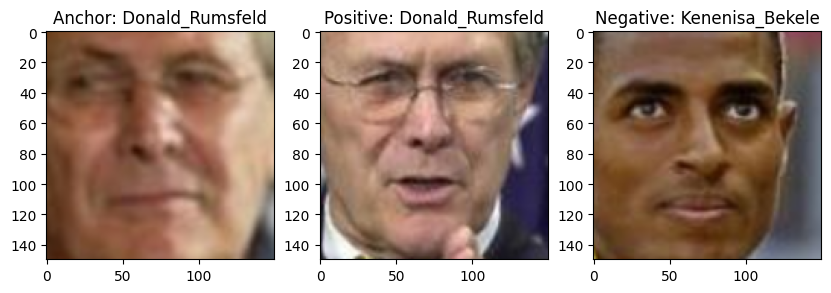

In [31]:
y_test_num = label_encoder.transform(y_test)
data_loader = SiameseDataLoaderTriplet(x_test, y_test_num, batch_size=1, image_shape= (150, 150, 3), return_labels= True, Augmentation=False)
for idx, sample in enumerate(data_loader):
  triplet, labels = sample
  labels = labels[0]
  anchor = triplet[0]
  positive = triplet[1]
  negative = triplet[2]
  imagem = anchor
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
  ax1.imshow(anchor[0]*255)
  ax1.set_title('Anchor: {}'.format(y_test[int(labels[0])]))
  ax2.imshow(positive[0]*255)
  ax2.set_title('Positive: {}'.format(y_test[int(labels[1])]))
  ax3.imshow(negative[0]*255)
  ax3.set_title('Negative: {}'.format(y_test[int(labels[2])]))
  break

In [32]:
anchor_embedding, positive_embedding, negative_embedding = (
    embedding_model(anchor),
    embedding_model(positive),
    embedding_model(negative)
  )

In [33]:
cossine_similarity = metrics.CosineSimilarity()
similarity_anchor_positive = cossine_similarity(anchor_embedding, positive_embedding)
similarity_anchor_negative = cossine_similarity(anchor_embedding, negative_embedding)

print('Similarity Positive: {}'.format(similarity_anchor_positive))
print('Similarity Negative: {}'.format(similarity_anchor_negative))

Similarity Positive: 0.9446929693222046
Similarity Negative: 0.4581550657749176
